# Random Acts of Pizza - Final Project
## Authors: Ben Arnoldy, Mary Boardman, Zach Merritt, and Kevin Gifford
#### Kaggle Competition Description:
In machine learning, it is often said there are no free lunches. How wrong we were.

This competition contains a dataset with 5671 textual requests for pizza from the Reddit community Random Acts of Pizza together with their outcome (successful/unsuccessful) and meta-data. Participants must create an algorithm capable of predicting which requests will garner a cheesy (but sincere!) act of kindness.

"I'll write a poem, sing a song, do a dance, play an instrument, whatever! I just want a pizza," says one hopeful poster. What about making an algorithm?

Kaggle is hosting this competition for the machine learning community to use for fun and practice. This data was collected and graciously shared by Althoff et al. (Buy them a pizza -- data collection is a thankless and tedious job!) We encourage participants to explore their accompanying paper and ask that you cite the following reference in any publications that result from your work:

Tim Althoff, Cristian Danescu-Niculescu-Mizil, Dan Jurafsky. How to Ask for a Favor: A Case Study on the Success of Altruistic Requests, Proceedings of ICWSM, 2014.
_______________________________________________________________________________________________

## Section 1: Load and Process Data
#### Load the 'Random Acts of Pizza' train and test data and perform basic processing

### A. Load Data and Modules

In [103]:
# Data and Data Structures
import json
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
from subprocess import check_output
import re

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.decomposition import NMF, LatentDirichletAllocation

#NLP
import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
#source: https://www.kaggle.com/alvations/basic-nlp-with-nltk
#nltk.download('stopwords')
#nltk.download('brown')
#nltk.download('wordnet')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')

# Visualization
%matplotlib inline
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
plt.style.use('bmh')
from wordcloud import WordCloud, STOPWORDS

ModuleNotFoundError: No module named 'wordcloud'

In [61]:
# Load Train Data
with open('../data/train.json') as fin:
    trainjson = json.load(fin)
train = pd.io.json.json_normalize(trainjson)

# Load Test Data
with open('../data/test.json') as fin:
    testjson = json.load(fin)
test = pd.io.json.json_normalize(testjson)

print("Train Shape:", train.shape)
print("Test Shape:", test.shape)

Train Shape: (4040, 32)
Test Shape: (1631, 17)


### B1. Find any missing values

In [3]:
train.isnull().sum()

giver_username_if_known                                    0
number_of_downvotes_of_request_at_retrieval                0
number_of_upvotes_of_request_at_retrieval                  0
post_was_edited                                            0
request_id                                                 0
request_number_of_comments_at_retrieval                    0
request_text                                               0
request_text_edit_aware                                    0
request_title                                              0
requester_account_age_in_days_at_request                   0
requester_account_age_in_days_at_retrieval                 0
requester_days_since_first_post_on_raop_at_request         0
requester_days_since_first_post_on_raop_at_retrieval       0
requester_number_of_comments_at_request                    0
requester_number_of_comments_at_retrieval                  0
requester_number_of_comments_in_raop_at_request            0
requester_number_of_comm

No missing data except in column "requester_user_flair." We see in the next section that this isn't a column in the test data, so we elected to not use it to train the model. 

### B2. Identify common columns between test and train

In [62]:
print("Common columns in train and test:")
print(train.columns[train.columns.isin(test.columns)])
print("----")
print("Columns in train but NOT test:")
print(train.columns[~train.columns.isin(test.columns)])

Common columns in train and test:
Index(['giver_username_if_known', 'request_id', 'request_text_edit_aware',
       'request_title', 'requester_account_age_in_days_at_request',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_on_raop_at_request',
       'requester_number_of_subreddits_at_request',
       'requester_subreddits_at_request',
       'requester_upvotes_minus_downvotes_at_request',
       'requester_upvotes_plus_downvotes_at_request', 'requester_username',
       'unix_timestamp_of_request', 'unix_timestamp_of_request_utc'],
      dtype='object')
----
Columns in train but NOT test:
Index(['number_of_downvotes_of_request_at_retrieval',
       'number_of_upvotes_of_request_at_retrieval', 'post_was_edited',
       'request_number_of_comments_at_retrieval', 'request_text',
       '

As can be seen above, there is a series of columns in the training data only. These columns reflect data about the post (e.g., the number of upvotes) at the time this Reddit data was retrieved.

### C. Create training data, labels, and 'in training only' data

In [63]:
train_labels_master = train[['requester_received_pizza']]
train_data_master = train[test.columns & train.columns]
train_only_data_master = train[train.columns[~train.columns.isin(test.columns)]].drop(['requester_received_pizza'], axis = 1)

In [64]:
print(train.shape, train_data_master.shape)

(4040, 32) (4040, 17)


### D. Set column types and profile

In [65]:
train_data_master = train_data_master.assign(
    unix_timestamp_of_request = pd.to_datetime(
        train_data_master.unix_timestamp_of_request, unit = "s"),
    unix_timestamp_of_request_utc = pd.to_datetime(
        train_data_master.unix_timestamp_of_request_utc, unit = "s"))

In [66]:
train_data_master.describe()
train_data_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4040 entries, 0 to 4039
Data columns (total 17 columns):
giver_username_if_known                               4040 non-null object
request_id                                            4040 non-null object
request_text_edit_aware                               4040 non-null object
request_title                                         4040 non-null object
requester_account_age_in_days_at_request              4040 non-null float64
requester_days_since_first_post_on_raop_at_request    4040 non-null float64
requester_number_of_comments_at_request               4040 non-null int64
requester_number_of_comments_in_raop_at_request       4040 non-null int64
requester_number_of_posts_at_request                  4040 non-null int64
requester_number_of_posts_on_raop_at_request          4040 non-null int64
requester_number_of_subreddits_at_request             4040 non-null int64
requester_subreddits_at_request                       4040 non-null obj

## Section 2: EDA
#### Conduct an Exploratory Data Analysis (EDA) to explore the data set

### A. Print Example Posts

In [67]:
for a in [False, True]:
    for b in range(2):
        print("requester_received_pizza ==",a)
        print("------")
        i = train[train['requester_received_pizza']==a].index[b]
        print('UID:\t', trainjson[i]['request_id'], '\n')
        print('Title:\t', trainjson[i]['request_title'], '\n')
        print('Text:\t', trainjson[i]['request_text_edit_aware'], '\n')
        print('Tag:\t', trainjson[i]['requester_received_pizza'], end='\n')
        print("______________________________________")
    print("______________________________________")

requester_received_pizza == False
------
UID:	 t3_l25d7 

Title:	 Request Colorado Springs Help Us Please 

Text:	 Hi I am in need of food for my 4 children we are a military family that has really hit hard times and we have exahusted all means of help just to be able to feed my family and make it through another night is all i ask i know our blessing is coming so whatever u can find in your heart to give is greatly appreciated 

Tag:	 False
______________________________________
requester_received_pizza == False
------
UID:	 t3_rcb83 

Title:	 [Request] California, No cash and I could use some dinner 

Text:	 I spent the last money I had on gas today. Im broke until next Thursday :( 

Tag:	 False
______________________________________
______________________________________
requester_received_pizza == True
------
UID:	 t3_14gmeb 

Title:	 [REQUEST] I'll give a two week xbox live code for a slice of pie! 

Text:	 Feeling under the weather so I called out off work today! I hate requestin

### B. Visualize Dependent Variable: Did the requester recieve a pizza?

C:\Users\zmerritt\AppData\Local\Continuum\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


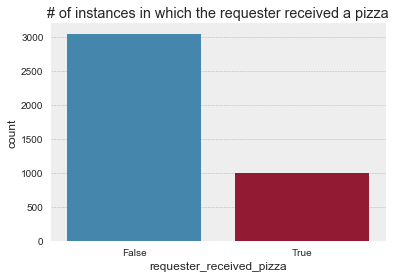

In [12]:
(sns.countplot(x = train_labels_master.requester_received_pizza).
set_title("# of instances in which the requester received a pizza"));

### C. Visualize All Numeric Fields

#### 1. Train and Test Data Visualization

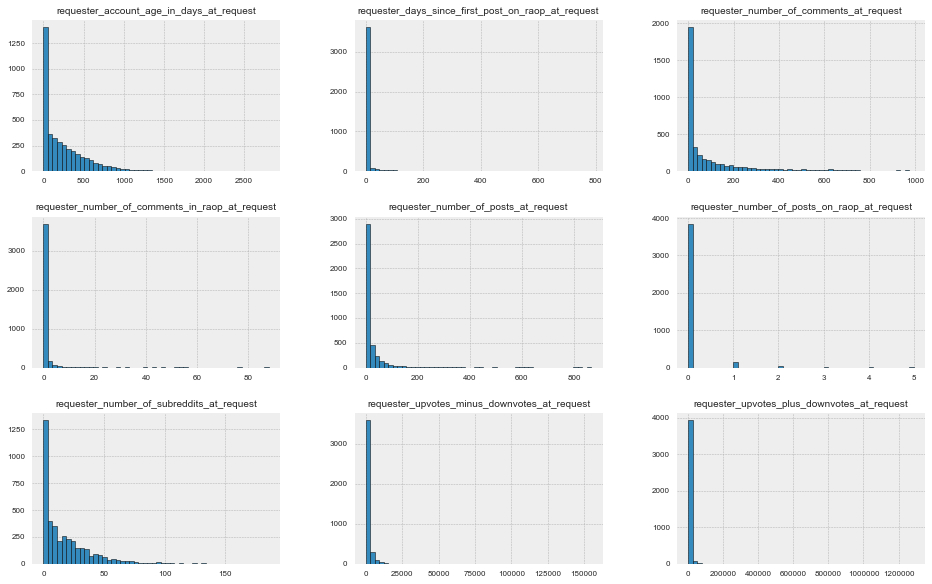

In [13]:
df_num = (train_data_master.select_dtypes(include = ['float64', 'int64']))
df_num.shape

fig = df_num.hist(figsize=(16, 10), bins=50, xlabelsize=8, ylabelsize=8, ec="k")
fig = [x.title.set_size(10) for x in fig.ravel()]
fig;

#### 2. Train (Only) Visualization

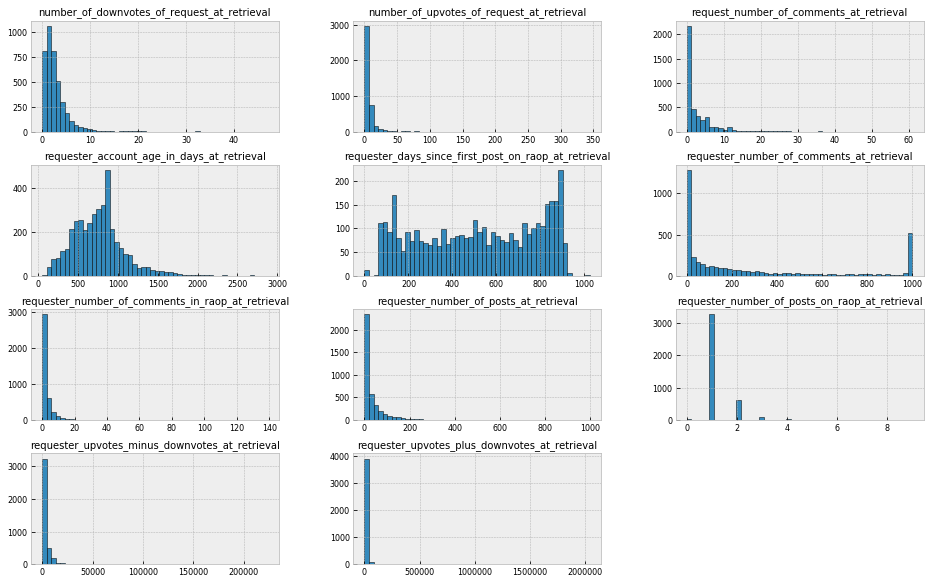

In [156]:
df_num = (train_only_data_master) # All columns are numeric
df_num.shape

fig = df_num.hist(figsize=(16, 10), bins=50, xlabelsize=8, ylabelsize=8, ec="k")
fig = [x.title.set_size(10) for x in fig.ravel()]
fig;

### D. Visualize requests and granted requests over time

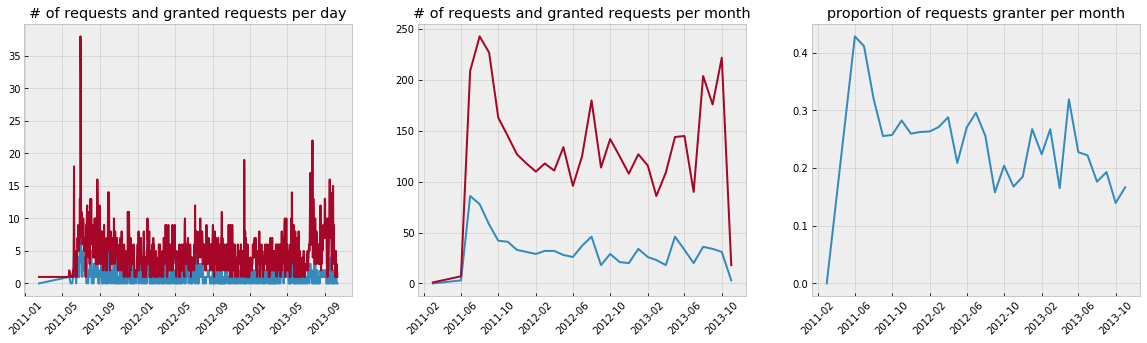

In [157]:
# Data setup
ts = pd.DataFrame({'granted requests':train_labels_master.requester_received_pizza.tolist(),
                  'requests':[1] * train_labels_master.shape[0]},
                index = train_data_master.unix_timestamp_of_request.dt.date.tolist())
ts = ts.groupby(ts.index).sum()
ts_month = pd.DataFrame({'granted requests':train_labels_master.requester_received_pizza.tolist(),
                  'requests':[1] * train_labels_master.shape[0]},
                index = (train_data_master.unix_timestamp_of_request.dt.date + pd.offsets.MonthBegin(0)).tolist())
ts_month = ts_month.groupby(ts_month.index).sum()

# Plots
# 1. By day
plt.figure(figsize=(20, 5))
plt.subplot(1,3,1)
plt.plot(ts)
plt.title("# of requests and granted requests per day")
plt.xticks(rotation=45)

# 2. By Month
plt.subplot(1,3,2)
plt.plot(ts_month)
plt.title("# of requests and granted requests per month")
plt.xticks(rotation=45)

# 3. By Month (prop)
plt.subplot(1,3,3)
plt.plot(ts_month.assign(prop_granted = ts_month['granted requests'] / ts_month['requests'])['prop_granted'])
plt.title("proportion of requests granter per month")
plt.xticks(rotation=45)

plt.show()

As seen above, there was a spike of requests in the in mid 2011 and in the end of 2013. However, besides those periods, the number of requests has remained relatively stagnant at 100 - 150 per month. 

Additionally, while there is a slight downward trend to the proportion of requests granted, the proportion has also remained relatively stagnant at 15% to 30% of requests being granted per month.

### E. Generate Word Clouds of Granted and Ungranted Requests

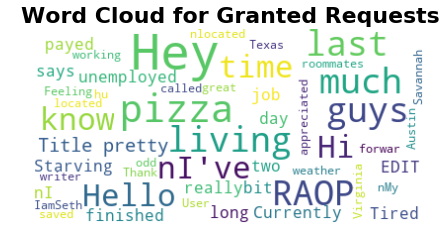

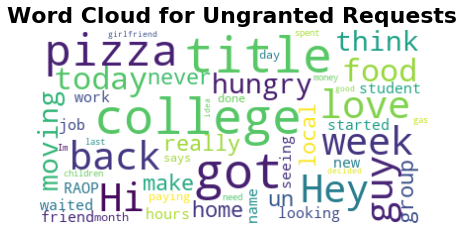

In [158]:
granted = train_data_master[train_labels_master['requester_received_pizza']==True]
ungranted = train_data_master[train_labels_master['requester_received_pizza']==False]

mpl.rcParams['font.size']=12        
mpl.rcParams['savefig.dpi']=100         
mpl.rcParams['figure.subplot.bottom']=.1 

stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=50,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(granted['request_text_edit_aware']))

fig = plt.figure(1)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.tight_layout(pad=0)
plt.title("Word Cloud for Granted Requests",fontsize=22, fontweight='bold')
plt.show()

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=50,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(ungranted['request_text_edit_aware']))

fig = plt.figure(1)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.tight_layout(pad=0)
plt.title("Word Cloud for Ungranted Requests",fontsize=22, fontweight='bold')
plt.show()

## Section 3: Establish Train/Test Sets and Generic Function

### A. Set Train/Test

Note: We used a development data set throughout our process. However, in this final report we only use the test and train process.

In [177]:
# Isolate the text column for the training and dev dataframes
x_atrain, x_atest, y_train, y_test = train_test_split(
   train,
   train_labels_master.values.ravel(), test_size=0.29, random_state=0)

# x_atrain and x_atest contain all columns (including ones which are only in the original "test" data)
# We impute these values later
x_train = x_atrain[test.columns & train.columns]
x_test = x_atest[test.columns & train.columns]

print("Our Train Shape:", x_train.shape)
print("Our Test Shape:", x_test.shape)

Our Train Shape: (2868, 17)
Our Test Shape: (1172, 17)


### B. Model Report Function

In [84]:
# Below is the code used throughout the project to generate reports for each model

def model_report(title, y_test, predictions):

    """
    Output: Classification report, confusion matrix, and ROC curve
    """
    print(title)
    print("---------")
    predictions_proba = predictions[:,1]
    predictions = predictions_proba > .5
    print(classification_report(y_test, predictions))

    cm = metrics.confusion_matrix(y_test, predictions)
    plt.figure(figsize=(3,3))
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy: {0}'.format(round(metrics.accuracy_score(y_test, predictions),2))
    plt.title(all_sample_title, size = 14)
    plt.show()
    
    fpr, tpr, threshold = metrics.roc_curve(y_test, predictions_proba)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## Section 4: Naive Bayes Baseline
#### Create a baseline Naive Bayes model using text (non-numeric) fields only. 

### A. Preprocessing

In [69]:
# Create Sparse matrix of words
count_vect = CountVectorizer()

# Apply to train and test data
x_trainNB = count_vect.fit_transform(x_train['request_text_edit_aware'])
x_testNB = count_vect.transform(x_test['request_text_edit_aware'])

# Print the first and last five words
cv_feature_names = count_vect.get_feature_names()
print("First five words:")
print(cv_feature_names[:5])
print("Last five words:")
print(cv_feature_names[-5:])

First five words:
['00', '000', '0000', '0011011001111000', '00pm']
Last five words:
['zrssbvz', 'zsk5c3o', 'zucchini', 'zuuri', 'zza']


### B. Train Model and Print Results

Naive Bayes (using text field only)
---------
             precision    recall  f1-score   support

      False       0.78      0.85      0.81       891
       True       0.33      0.24      0.28       281

avg / total       0.67      0.70      0.68      1172



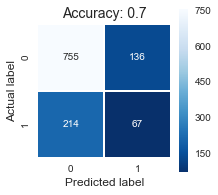

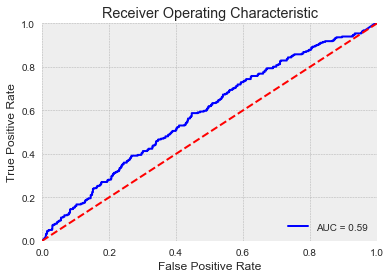

In [85]:
# All parameters not specified are set to their defaults
nb = BernoulliNB()
nb.fit(x_trainNB, y_train)
predictions = nb.predict_proba(x_testNB)

model_report("Naive Bayes (using text field only)",y_test, predictions)

## Section 5: Logistic Regression Baseline
#### Create a baseline Logisitic Regression model using non-text (numeric) fields only. 

### A. Preprocessing

In [86]:
# Normalize all fields (numeric)
min_max_scaler = preprocessing.MinMaxScaler()
x_trainLR = min_max_scaler.fit_transform(
    x_train.select_dtypes(include = ['float64', 'int64','datetime64[ns]']).apply(pd.to_numeric).values)

# Apply to test set
x_testLR = min_max_scaler.transform(
    x_test.select_dtypes(include = ['float64', 'int64','datetime64[ns]']).apply(pd.to_numeric).values)

### B. Train Model and Print Results

Logistic Regression (using only common numeric fields)
---------
             precision    recall  f1-score   support

      False       0.77      1.00      0.87       891
       True       0.69      0.03      0.06       281

avg / total       0.75      0.76      0.67      1172



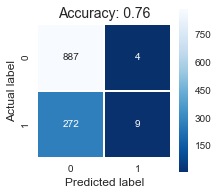

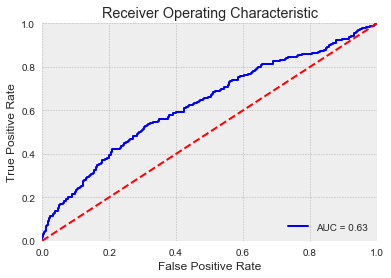

In [87]:
# All parameters not specified are set to their defaults
logisticRegr = LogisticRegression()
logisticRegr.fit(x_trainLR, y_train)
predictions = logisticRegr.predict_proba(x_testLR)

# Output model report
model_report("Logistic Regression (using only common numeric fields)",y_test, predictions)

## Section 6: Winning Model

### Improved Logistic Regression

To make improvements on our baseline, we normalized the numeric data and conducted feature engineering to our baseline Logistic Regression model. Then, we vectorized our text data using CountVectorizer, and reduced dimensionality using Truncated SVD. We then determined the optimal number of SVD components. Because there were features in training data not present in the test data, we imputed the features for the test data using a random forest regressor. 

Finally, we determined the optimal logistic regression regularization before running our final model. Ultimately, we were able to improve the AUC (Area under the ROC Curve) score by 5 points above the logistic regression baseline.

### A. Clean and Standardize Text Field

#### 1. Define Clean Text Field Functions

In [206]:
stopwords_en = set(stopwords.words('english'))
wnl = WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 
    
def word_tokenize2(text):
    return(text.split())
    
def lemmatize_sent(text): 
    # Text input is string, returns lowercased strings.
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(word_tokenize2(text))]

def text_standardize(s):
    s =  re.compile("[^\w']|_").sub(" ",s.lower())
    s = re.sub(' +',' ', s)
    return s

def word_clean(data):
    """
    Remove stop words.
    Apply NLP to make walk, walking, walked all the same word.
    Only keep nouns and adjective.
    Remove words that I think are messing things up (e.g, pizza, reddit)
    """
    clean_data = []
    for i in range(len(data)):
        querywords = lemmatize_sent(data[i])
        resultwords  = [text_standardize(word) for word in querywords if word.lower() 
                        not in stopwords_en 
                        and not word.isdigit() and not word == "pizza"  and not word == "request"]
        tags = nltk.pos_tag(resultwords)
        resultwords_pos =  [word for word,pos in tags if (pos == 'NN' or pos == 'NNP' or 
                                                          pos == 'NNS' or pos == 'NNPS' or
                                                          pos == 'JJ' or pos == "JJR" or
                                                          pos == "JJS") or (word == "please")]
        result = ' '.join(resultwords_pos)
        clean_data.append(result)
    return clean_data

#### 2. Apply Clean Text Field Functions

In [207]:
x_train = x_train.assign(request_title = word_clean(x_train['request_title'].tolist()))
x_train = x_train.assign(request_title = word_clean(x_train['request_text_edit_aware'].tolist()))
x_test = x_test.assign(request_title = word_clean(x_test['request_title'].tolist()))
x_test = x_test.assign(request_title = word_clean(x_test['request_text_edit_aware'].tolist()))

### B. Feature Engineering

In [180]:
def make_features(vocab):
    # This function takes as input a string list of words
    # It outputs four np.arrays: 
    # 1. Train data feature dealing with title text
    # 2. Train data feature dealing with body text
    # 3. Test data feature dealing with title text
    # 4. Test data feature dealing with body text

    # Initialize feature variables to 0
    train_feature_title = np.zeros(shape = (x_train.shape[0],1))
    train_feature_body = np.zeros(shape = (x_train.shape[0],1))
    test_feature_title = np.zeros(shape = (x_test.shape[0],1))
    test_feature_body = np.zeros(shape = (x_test.shape[0],1))

    # Look through each training sample for occurences of vocab words
    for sample_row in range(x_train.shape[0]):
        title_text = str(x_train.request_title.iloc[sample_row]).lower()
        body_text = str(x_train.request_text_edit_aware.iloc[sample_row]).lower() 
    
        for word in vocab:
            if word in title_text:
                train_feature_title[sample_row] = 1
            if word in body_text:
                train_feature_body[sample_row] = 1            
        
    # Look through each test sample for occurences of vocab words
    for sample_row in range(x_test.shape[0]):
        title_text = str(x_test.request_title.iloc[sample_row]).lower()
        body_text = str(x_test.request_text_edit_aware.iloc[sample_row]).lower()

        for word in vocab:
            if word in title_text:
                test_feature_title[sample_row] = 1
            if word in body_text:
                test_feature_body[sample_row] = 1

    return(train_feature_title, train_feature_body, test_feature_title, test_feature_body)

#### 1. Real hunger
The idea here: People who literally don't have enough to eat could elicit sympathetic responses.

In [181]:
vocab = ['pantry','shelter','homeless','nowhere','nothing']
train_hunger_title, train_hunger_body, test_hunger_title, test_hunger_body = make_features(vocab)

#### 2. In-group features
The idea here: People who reference the reddit community and the lingo may be more sympathetic. 

In [182]:
vocab = ['roap', 'reddit']
train_ingroup_title, train_ingroup_body, test_ingroup_title, test_ingroup_body = make_features(vocab)

#### 3. Student features
The idea here: Students may be sympathetic. Found that most student terms were unhelpful, but 'ramen' was a winner.

In [183]:
vocab = ['ramen']
train_student_title, train_student_body, test_student_title, test_student_body = make_features(vocab)

#### 4. 'You're a good person' features
The idea here: People may be more inclined to give pizza to those who seem to be good people. 

In [184]:
vocab = ['bless','generosity','kind','generous']
train_goodie_title, train_goodie_body, test_goodie_title, test_goodie_body = make_features(vocab)

#### 5. Religious features
The idea here: I'm a good Christian, now buy me a pizza!

In [185]:
vocab = ['lord','prayer','savior','personal','saved','forgiven', 'mercy']
train_god_title, train_god_body, test_god_title, test_god_body ,= make_features(vocab)

#### 6. Gratitude / politeness features
The idea here: What's the magic word?

In [186]:
vocab = ['please', 'thank', 'thanks']
train_polite_title, train_polite_body, test_polite_title, test_polite_body = make_features(vocab)

#### 7. Expenses features
The idea here: Don't tell me you're broke or poor (these were losers), tell me specific expenses. Tell me how the rent is too high!

In [187]:
vocab = ['rent','car']
train_expenses_title, train_expenses_body, test_expenses_title, test_expenses_body = make_features(vocab)

#### 8. Hard work features
The idea here: More sympathy when someone is trying.

In [188]:
vocab = ['work','job', 'tight']
train_work_title, train_work_body, test_work_title, test_work_body = make_features(vocab)

#### 9. Celebration features
The idea here: Wanting to celebrate happy events (with a pizza)!

In [189]:
vocab = ['birthday','wedding','married','engaged','bday','b-day','anniversary']
train_celebrate_title, train_celebrate_body, test_celebrate_title, test_celebrate_body = make_features(vocab)

#### 10. Gender-based features
The idea here: Buy an attractive woman a pizza.

In [190]:
vocab = ['hot','hawt','female','woman','chick','babe','lonely']
train_chicks_title, train_chicks_body, test_chicks_title, test_chicks_body = make_features(vocab)

#### 11. Title/body text length features
The idea here: People may get tired of reading long text or may need more details from posts/titles that are too short. 

In [191]:
def small(data, size):
    
    # Initialize feature variable to 0
    issmall = np.zeros(shape = (data.shape[0],1))
    counter = 0

    # Look through each training sample for body text size
    for sample in data:
        if len(sample) < size:
            issmall[counter] = 1
        counter +=1
    return(issmall)
            
def large(data, size):
    
    # Initialize feature variable to 0
    islarge = np.zeros(shape = (data.shape[0],1))
    counter = 0

    # Look through each training sample for body text size
    for sample in data:
        if len(sample) > size:
            islarge[counter] = 1
        counter +=1
    return(islarge)

def charcount(data):
    
    # Initialize feature variable to 0
    numchars = np.zeros(shape = (data.shape[0],1))
    counter = 0

    # Look through each training sample and count the text length
    for sample in data:
        numchars[counter] = len(sample)
        counter +=1
        
    return(numchars)

def readable(data):

    # Features created with this function did help with initial accuracy but not after SVD
    
    # Initialize feature variable to 0
    readability = np.zeros(shape = (data.shape[0],1))
    counter = 0

    # Look through each training sample and get readability score
    for sample in data:
        try:
            readability[counter] = textstat.dale_chall_readability_score(str(sample))
        except:
            readability[counter] = 0
        counter +=1
        
    return(readability)

def readable2(data):

    # Features created with this function did help with initial accuracy but not after SVD
    
    # Initialize feature variable to 0
    readability = np.zeros(shape = (data.shape[0],1))
    counter = 0

    # Look through each training sample and get another readability score
    for sample in data:
        try:
            readability[counter] = textstat.flesch_reading_ease(str(sample))
        except:
            readability[counter] = 0
        counter +=1
        
    return(readability)

#### 13. Train Draft Model and Print Results

Logistic Regression (normalized)
---------
             precision    recall  f1-score   support

      False       0.77      0.99      0.87       891
       True       0.68      0.06      0.11       281

avg / total       0.75      0.77      0.69      1172



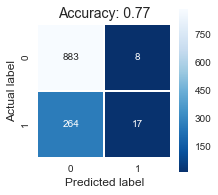

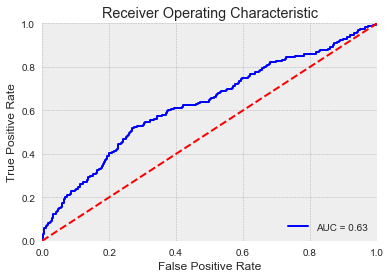

(2868, 30) (2868, 11)
Logistic Regression (with feature engineering)
---------
             precision    recall  f1-score   support

      False       0.78      0.99      0.87       891
       True       0.72      0.09      0.16       281

avg / total       0.76      0.77      0.70      1172



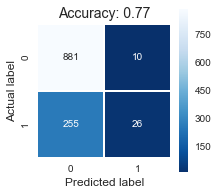

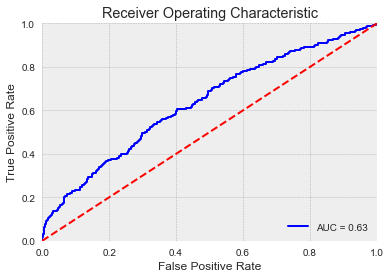

In [192]:
# Normalize all fields (numeric)
min_max_scaler = preprocessing.MinMaxScaler()
x_train_scaled = min_max_scaler.fit_transform(
    x_train.select_dtypes(include = ['float64', 'int64','datetime64[ns]']).apply(pd.to_numeric).values)
x_test_scaled = min_max_scaler.fit_transform(
    x_test.select_dtypes(include = ['float64', 'int64','datetime64[ns]']).apply(pd.to_numeric).values)

# Train normalized logistic regression model
logisticRegr = LogisticRegression()
logisticRegr.fit(x_train_scaled, y_train)
predictions = logisticRegr.predict_proba(x_test_scaled)

# Output normalized logistic regression model report
model_report("Logistic Regression (normalized)",y_test, predictions)

x_train_full = x_train_scaled.copy()
x_test_full = x_test_scaled.copy()

# Add new bernoulli features to the train and test data
x_train_full = np.append(x_train_full, train_ingroup_title, 1) 
x_train_full = np.append(x_train_full, train_ingroup_body, 1) 
x_test_full = np.append(x_test_full, test_ingroup_title, 1) 
x_test_full = np.append(x_test_full, test_ingroup_body, 1) 
x_train_full = np.append(x_train_full, train_student_title, 1)  
x_train_full = np.append(x_train_full, train_student_body, 1) 
x_test_full = np.append(x_test_full, test_student_title, 1) 
x_test_full = np.append(x_test_full, test_student_body, 1) 
x_train_full = np.append(x_train_full, train_goodie_title, 1)
x_train_full = np.append(x_train_full, train_goodie_body, 1)
x_test_full = np.append(x_test_full, test_goodie_title, 1)
x_test_full = np.append(x_test_full, test_goodie_body, 1)
x_train_full = np.append(x_train_full, train_god_title, 1) 
x_train_full = np.append(x_train_full, train_god_body, 1) 
x_test_full = np.append(x_test_full, test_god_title, 1) 
x_test_full = np.append(x_test_full, test_god_body, 1) 
x_train_full = np.append(x_train_full, train_polite_title, 1) 
x_train_full = np.append(x_train_full, train_polite_body, 1)  
x_test_full = np.append(x_test_full, test_polite_title, 1) 
x_test_full = np.append(x_test_full, test_polite_body, 1) 
x_train_full = np.append(x_train_full, train_expenses_title, 1)
x_train_full = np.append(x_train_full, train_expenses_body, 1)
x_test_full = np.append(x_test_full, test_expenses_title, 1)
x_test_full = np.append(x_test_full, test_expenses_body, 1)
x_train_full = np.append(x_train_full, train_work_title, 1) 
x_train_full = np.append(x_train_full, train_work_body, 1) 
x_test_full = np.append(x_test_full, test_work_title, 1) 
x_test_full = np.append(x_test_full, test_work_body, 1) 
x_train_full = np.append(x_train_full, train_celebrate_title, 1) 
x_train_full = np.append(x_train_full, train_celebrate_body, 1) 
x_test_full = np.append(x_test_full, test_celebrate_title, 1) 
x_test_full = np.append(x_test_full, test_celebrate_body, 1) 
x_train_full = np.append(x_train_full, train_chicks_title, 1) 
x_train_full = np.append(x_train_full, train_chicks_body, 1) 
x_test_full = np.append(x_test_full, test_chicks_title, 1) 
x_test_full = np.append(x_test_full, test_chicks_body, 1) 

# Add Bernoulli features small / large
x_train_full = np.append(x_train_full, small(x_train.request_title,20), 1)
x_test_full = np.append(x_test_full, small(x_test.request_title,20), 1)

print(x_train_full.shape, x_train_scaled.shape)

# Train normalized logistic regression model with feature engineering
logisticRegr = LogisticRegression()
logisticRegr.fit(x_train_full, y_train)
predictions = logisticRegr.predict_proba(x_test_full)

model_report("Logistic Regression (with feature engineering)",y_test, predictions)

As we can see with the above models, normalizing the numeric data improves the logistic regression baseline AUC score by 2 points. Then, with some feature engineering, we were able to improve this normalized logistic regression model by 3 points in the AUC score, compared to the baseline. 

### C. Vectorizer and Dimensionality Reduction

Next, we vectorized the text features using CountVectorizer and reduced the dimensionality with Truncated Singular Value Decomposition (SVD). We used Truncated SVD instead of Principal Components Analysis (PCA) because we are using a sparse matrix of data, instead of a dense one. Then, we determined the optimal number of components before adding this dimension-reduced and vectorized text data to the numeric data. 

In [216]:
# Create Sparse matrix of words
count_vect = CountVectorizer() 
vect_train_body = count_vect.fit_transform(x_train.request_text_edit_aware)
vect_test_body = count_vect.transform(x_test.request_text_edit_aware)

def boildown (svd_comps):
    
    # Reduce the vectorized word feature to small number of numerical components
    svd_body = TruncatedSVD(n_components=svd_comps)
    svd_train_body = svd_body.fit_transform(vect_train_body)
    svd_test_body = svd_body.fit_transform(vect_test_body)

    # Add vectorized features to train and test
    x_train_newandvect = x_train_full.copy()
    x_test_newandvect = x_test_full.copy()
    for comp in range(svd_comps):
        x_train_newandvect = np.hstack((x_train_newandvect, svd_train_body[:,comp].reshape(-1,1)))
        x_test_newandvect = np.hstack((x_test_newandvect, svd_test_body[:,comp].reshape(-1,1)))

    # Train new feature + vectorized model
    logisticRegr = LogisticRegression()
    logisticRegr.fit(x_train_newandvect, y_train)
    predictions = logisticRegr.predict_proba(x_test_newandvect)
    
    # Compute AUC
    fpr, tpr, threshold = metrics.roc_curve(y_test, predictions[:,1])
    roc_auc = metrics.auc(fpr, tpr)
    
    return(roc_auc, x_train_newandvect, x_test_newandvect)

best_auc = 0 # Stores best value
best_svd_comps = 0 # Stores index of best AUC

print("Please wait while the best SVD component number is found...")

for svd_comps_body in range(130):
    auc, x_train_try, x_test_try = boildown(svd_comps_body)
    if auc > best_auc:
        best_auc = auc
        best_svd_comps = svd_comps_body
        x_train_vect = x_train_try.copy()
        x_test_vect = x_test_try.copy()

print("The best AUC score for various SVD component numbers was", best_auc)
print("The best SVD component number was", best_svd_comps)


Please wait while the best SVD component number is found...
The best AUC score for various SVD component numbers was 0.646616421231
The best SVD component number was 57


In [218]:
auc, x_train_vect, x_test_vect = boildown(svd_comps = 57)

### D. Input Values for Features Not Provided in the Original "Test" Data

The training data has features that do not appear in the test data. To address this, we imputed the features for the test data using a random forest regressor. 

In [219]:
# All the features
cols_to_impute = ['number_of_downvotes_of_request_at_retrieval','number_of_upvotes_of_request_at_retrieval',
                  'request_number_of_comments_at_retrieval','requester_account_age_in_days_at_retrieval',
                  'requester_days_since_first_post_on_raop_at_retrieval','requester_number_of_comments_at_retrieval',
                  'requester_number_of_comments_in_raop_at_retrieval','requester_number_of_posts_at_retrieval',
                  'requester_number_of_posts_on_raop_at_retrieval','requester_upvotes_minus_downvotes_at_retrieval',
                  'requester_upvotes_plus_downvotes_at_retrieval']
    
col_count = 0 # Keeps track of new columns to create
col_to_add = [] # Stores list of columns to add

x_train_fullimputed = x_train_vect.copy()
x_test_fullimputed = x_test_vect.copy()

for col_to_predict in cols_to_impute:
        
    regr_multirf = RandomForestRegressor(max_depth=7,random_state=0)

    new_col = x_atrain[col_to_predict].apply(pd.to_numeric).values.reshape(-1,1)
    
    # Scale train_labels
    min_max_scaler = preprocessing.MinMaxScaler()
    new_col_scaled = min_max_scaler.fit_transform(new_col)

    # Impute                                    
    regr_multirf.fit(x_train_vect, new_col_scaled.ravel())
    predicted_col = regr_multirf.predict(x_test_vect).reshape(-1,1)
    
    # Add the feature to both train and test
    x_train_fullimputed = np.hstack((x_train_fullimputed, new_col_scaled))
    x_test_fullimputed = np.hstack((x_test_fullimputed, predicted_col))
    
    col_count += 1

C:\Users\zmerritt\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)
C:\Users\zmerritt\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)
C:\Users\zmerritt\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)
C:\Users\zmerritt\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)
C:\Users\zmerritt\AppData\Local\Cont

### E. Apply Non-Negative Matrix Factorization for "Topic Analysis"

In [233]:
#source: https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

#no_features_range = [500,1000,2000,4000]
#no_topics_range = [10,50,100,500,1000,2000,4000]  

#no_features_range = [3000,4000,5000,10000]
#no_topics_range = [90,100,150,200,250]  

no_features_range = [2500, 3000,3500]
no_topics_range = [100,110]  

no_features_used = []
no_topics_used = []
roc_auc_found = []

for i in range(len(no_features_range)):
    print(i)
    for a in range(len(no_topics_range)):
        no_features = no_features_range[i]
        no_topics = no_topics_range[a]
        
        if no_features > no_topics:
            # NMF is able to use tf-idf
            tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
            tfidf = tfidf_vectorizer.fit_transform(x_train['request_text_edit_aware'].tolist())
            tfidf_feature_names = tfidf_vectorizer.get_feature_names()



            # Run NMF
            nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

            #no_top_words = 10
            #print("NMF Topics:")
            #display_topics(nmf, tfidf_feature_names, no_top_words)

            #Apply NMF Transformation

            #train
            nmf_train = nmf.transform(tfidf)
            tfidf_test = tfidf_vectorizer.transform(x_test['request_text_edit_aware'].tolist())
            nmf_test = nmf.transform(tfidf_test)
            nmf_test = nmf.transform(tfidf_test)

            logisticRegr = LogisticRegression()
            logisticRegr.fit(nmf_train, y_train)
            predictions = logisticRegr.predict_proba(nmf_test)

            # Compute AUC
            fpr, tpr, threshold = metrics.roc_curve(y_test, predictions[:,1])
            roc_auc = metrics.auc(fpr, tpr)

            #Append
            no_features_used.append(no_features)
            no_topics_used.append(no_topics)
            roc_auc_found.append(roc_auc)
            
max(roc_auc_found)
ind = roc_auc_found.index(max(roc_auc_found))
print("no_features_used:",no_features_used[ind])
print("no_topics_used:",no_topics_used[ind])

0
1
2


In [232]:
max(roc_auc_found)
ind = roc_auc_found.index(max(roc_auc_found))
print("no_features_used:",no_features_used[ind])
print("no_topics_used:",no_topics_used[ind])

no_features_used: 3000
no_topics_used: 100


In [235]:
no_features = 3000
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(x_train['request_text_edit_aware'].tolist())
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# Run NMF
no_topics = 100
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

no_top_words = 10
print("NMF Topics:")
display_topics(nmf, tfidf_feature_names, no_top_words)

#Apply NMF Transformation

nmf_train = nmf.transform(tfidf)
tfidf_test = tfidf_vectorizer.transform(x_test['request_text_edit_aware'].tolist())
nmf_test = nmf.transform(tfidf_test)
nmf_test = nmf.transform(tfidf_test)

#Add information to fullimputed
x_train_fullimputed = np.hstack((x_train_fullimputed,nmf_train))
x_test_fullimputed = np.hstack((x_test_fullimputed,nmf_test))

NMF Topics:
Topic 0:
zone fear fees feels feeling feel feeding feed fee fed
Topic 1:
pizza like good hut random free papa right kind need
Topic 2:
com http imgur jpg www youtube reddit comments watch png
Topic 3:
pay forward promise soon asap friday definitely comes check payday
Topic 4:
zone fear fees feels feeling feel feeding feed fee fed
Topic 5:
love pizza reading subreddit night surprise hot working spend year
Topic 6:
college student broke poor students loans kid meal starving say
Topic 7:
really right lately pizza broke bad shitty think starving afford
Topic 8:
just moved got new apartment times finished need figured started
Topic 9:
zone fear fees feels feeling feel feeding feed fee fed
Topic 10:
zone fear fees feels feeling feel feeding feed fee fed
Topic 11:
zone fear fees feels feeling feel feeding feed fee fed
Topic 12:
hungry broke pretty say music super tired reddit pass wanna
Topic 13:
zone fear fees feels feeling feel feeding feed fee fed
Topic 14:
thanks advance readi

### F. Apply  Latent Dirichlet Allocation for "Topic Analysis"

In [236]:
#source: https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730
no_features = 3000

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(x_train['request_text_edit_aware'].tolist())
tf_feature_names = tf_vectorizer.get_feature_names()

no_topics = 100

# Run LDA
lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', 
                                learning_offset=50.,random_state=0).fit(tf)

no_top_words = 10
print("LDA Topics:")
display_topics(lda, tf_feature_names, no_top_words)

#Apply LDA Transformation
#Only allow each observation to belong to ONE topic

#train
lda_train = lda.transform(tf)
lda_train_01 = np.zeros_like(lda_train)
lda_train_01[np.where(lda_train==np.max(lda_train))] = 1
x_train_fullimputed_topics = np.hstack((x_train_fullimputed, lda_train_01))

#test
tf_test = tf_vectorizer.transform(x_test['request_text_edit_aware'].tolist())
lda_test = lda.transform(tf_test)
lda_test_01 = np.zeros_like(lda_test)
lda_test_01[np.where(lda_test==np.max(lda_test))] = 1
x_test_fullimputed_topics = np.hstack((x_test_fullimputed, lda_test_01))

LDA Topics:
Topic 0:
im pizza random hungry dont acts really ramen ive food
Topic 1:
amp god help eat bless love student pay days broke
Topic 2:
work greatly location unexpected groceries ohio family week pizza add
Topic 3:
kidney stone tub pain blood stones missed cleveland hours batman
Topic 4:
band playing gigs stream arent potatos played hanging souls season
Topic 5:
electronic sounding cent road degree brings popped sophomore 50 county
Topic 6:
boyfriend potatoes glorious wasted convince jobless fired combination wishes fairy
Topic 7:
tuna gig existed arizona responsible deserving gotta drink start working
Topic 8:
love miss time tonight work really old friend pizza don
Topic 9:
northern scary needs worried pulling happily tomorrow poster city couldn
Topic 10:
weeks ve new job pay rent things say august issue
Topic 11:
santa ho clearly voice gc small return dominos kids fiancé
Topic 12:
festival uk gonna mid finance music knows 50 called hold
Topic 13:
appreciate thanks pickup pre

In [238]:
from tpot import TPOTClassifier


tpot = TPOTClassifier(generations=3, population_size=100, verbosity=2, scoring = "roc_auc")
tpot.fit(x_train_fullimputed_topics, y_train)
print(tpot.score(x_test_fullimputed_topics, y_test))
tpot.export('tpot_allfeats.py')

C:\Users\zmerritt\AppData\Local\Continuum\Anaconda3\lib\site-packages\deap\tools\_hypervolume\pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)


Generation 1 - Current best internal CV score: 0.8871615101019369


Generation 2 - Current best internal CV score: 0.8873019369767843


Generation 3 - Current best internal CV score: 0.8876843916842609



Best pipeline: ExtraTreesClassifier(MaxAbsScaler(input_matrix), bootstrap=False, criterion=gini, max_features=0.7, min_samples_leaf=12, min_samples_split=18, n_estimators=100)


ValueError: Found input variables with inconsistent numbers of samples: [2868, 1172]

In [239]:
print(tpot.score(x_test_fullimputed_topics, y_test))
tpot.export('tpot_allfeats.py')

0.660102408026


True

Random Forest Classifier
---------
             precision    recall  f1-score   support

      False       0.90      0.98      0.94      2155
       True       0.91      0.67      0.77       713

avg / total       0.90      0.90      0.90      2868



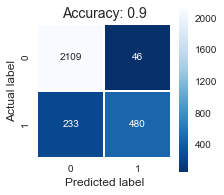

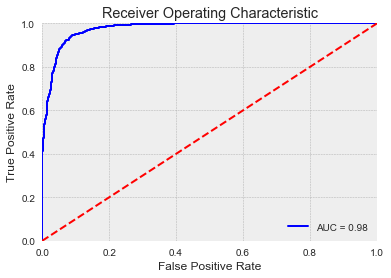

In [243]:
predictions = tpot.predict_proba(x_train_fullimputed_topics)
model_report("Random Forest Classifier",y_train, predictions)

Random Forest Classifier
---------
             precision    recall  f1-score   support

      False       0.79      0.94      0.86       891
       True       0.50      0.19      0.27       281

avg / total       0.72      0.76      0.72      1172



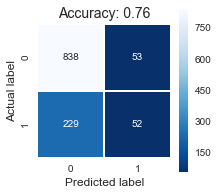

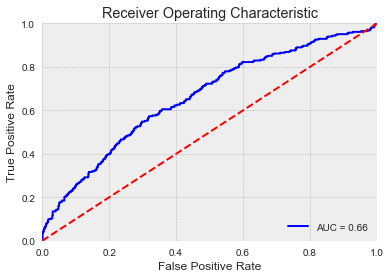

In [242]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MaxAbsScaler
exported_pipeline = make_pipeline(
    MaxAbsScaler(),
    ExtraTreesClassifier(bootstrap=False, criterion="gini", 
                         max_features=0.7000000000000001, min_samples_leaf=12, min_samples_split=18, n_estimators=100)
)
predictions = tpot.predict_proba(x_test_fullimputed_topics)
model_report("Random Forest Classifier",y_test, predictions)

Random Forest Classifier
---------
             precision    recall  f1-score   support

      False       0.78      0.95      0.86       891
       True       0.48      0.14      0.21       281

avg / total       0.71      0.76      0.70      1172



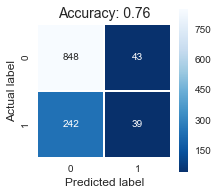

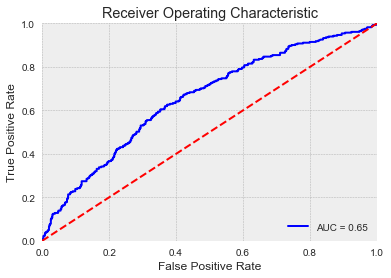

In [237]:
from sklearn.ensemble import RandomForestClassifier
clf =  RandomForestClassifier(bootstrap=True, criterion="entropy", 
                           max_features=0.2, min_samples_leaf=13, min_samples_split=5, n_estimators=100)

clf.fit(x_train_fullimputed_topics, y_train)
predictions = clf.predict_proba(x_test_fullimputed_topics)

#Output model report
model_report("Random Forest Classifier",y_test, predictions)

### E. Train and Run Final Model

Finally, we used GridSearchCV to determine the optimal C value for regularization before running our final (winning) Logistic Regression model.

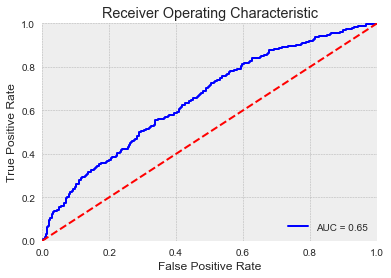

In [225]:
# Train Model
# All parameters not specified are set to their defaults
regularization = {'C': [10.0, 30.0, 50.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 1000.0]}

lr = LogisticRegression() # Penalty = 'l2'  
optimum_lr = GridSearchCV(lr, regularization)
lr_fit = optimum_lr.fit(x_train_fullimputed_topics, y_train)
predictions = lr_fit.predict_proba(x_test_fullimputed_topics)

#Output model report
model_report("Logistic Regression Final Model",y_test, predictions)

As we can see above, compared to the baseline logistic regression model, our final model increased the AUC (Area under the ROC Curve) by 7 points. Because the submissions were evaluated using AUC (https://www.kaggle.com/c/random-acts-of-pizza#evaluation), this is how we determined our winning model. Logistic Regression outperformed countless models, including Random Forrest and Neural Network classifiers.